# House Price Prediction

## Problem Statement
Predict the **sale price of houses** based on property features such as square footage, number of bedrooms, location (neighborhood), year built, and overall quality rating.

## Goal
- Generate and explore a realistic house pricing dataset (no external download needed)
- Preprocess features: scaling, encoding, feature engineering
- Train two regression models: **Linear Regression** and **Gradient Boosting**
- Visualize predicted vs. actual prices
- Evaluate performance using **MAE** and **RMSE**

## Dataset Source
A **synthetic but realistic** house price dataset is generated using NumPy with realistic correlations between features and prices — no Kaggle account or internet required.

---

## 1. Import Libraries

In [1]:
# ── Standard Libraries ──────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ── Scikit-Learn: Preprocessing ─────────────────────────────────────
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ── Scikit-Learn: Models ─────────────────────────────────────────────
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# ── Scikit-Learn: Metrics ────────────────────────────────────────────
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ── Plot Style ───────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Generate the Dataset

We generate a **synthetic but realistic** dataset of 2,000 houses with features like:
- `SqFt` — Square footage of living area
- `Bedrooms` — Number of bedrooms
- `Bathrooms` — Number of bathrooms
- `YearBuilt` — Year the house was built
- `GarageCars` — Garage capacity
- `LotSize` — Total lot size (sq ft)
- `Pool` — Whether the house has a pool
- `Floors` — Number of floors
- `OverallQual` — Overall quality rating (1–10)
- `Neighborhood` — Location category (8 neighborhoods)
- `HouseStyle` — Architectural style
- `Condition` — House condition (Excellent/Good/Fair/Poor)
- `SalePrice` — **Target variable** (USD)

In [2]:
np.random.seed(42)
n = 2000

# ── Categorical pools ────────────────────────────────────────────────
neighborhoods = ['Downtown', 'Suburbs', 'Uptown', 'Midtown',
                 'Eastside', 'Westside', 'Northend', 'Southend']
house_styles  = ['Ranch', 'Colonial', 'Victorian', 'Contemporary', 'Craftsman']
conditions    = ['Excellent', 'Good', 'Fair', 'Poor']

neigh     = np.random.choice(neighborhoods, n)
style     = np.random.choice(house_styles, n)
condition = np.random.choice(conditions, n, p=[0.20, 0.45, 0.25, 0.10])

# ── Numerical features ────────────────────────────────────────────────
sqft        = np.random.normal(1800, 600, n).clip(600, 5000).astype(int)
bedrooms    = np.random.choice([1,2,3,4,5,6], n, p=[0.03,0.15,0.35,0.30,0.12,0.05])
bathrooms   = np.random.choice([1,1.5,2,2.5,3,3.5,4], n,
                                p=[0.05,0.10,0.30,0.20,0.20,0.10,0.05])
year_built  = np.random.randint(1950, 2023, n)
garage      = np.random.choice([0,1,2,3], n, p=[0.10,0.30,0.45,0.15])
lot_size    = np.random.normal(8000, 3000, n).clip(2000, 30000).astype(int)
pool        = np.random.choice([0,1], n, p=[0.75, 0.25])
floors      = np.random.choice([1,2,3], n, p=[0.40, 0.50, 0.10])
overall_qual= np.random.choice(range(1,11), n,
                p=[0.02,0.03,0.05,0.08,0.12,0.18,0.22,0.16,0.10,0.04])

# ── Price generation with realistic correlations ──────────────────────
neigh_mult = {'Downtown':1.35,'Uptown':1.25,'Midtown':1.10,'Westside':1.05,
              'Suburbs':1.00,'Northend':0.95,'Eastside':0.90,'Southend':0.85}
cond_mult  = {'Excellent':1.20,'Good':1.00,'Fair':0.85,'Poor':0.70}

base_price = (
    sqft        * 150
    + bedrooms  * 8_000
    + bathrooms * 12_000
    + (2023 - year_built) * (-500)
    + garage    * 15_000
    + lot_size  * 3
    + pool      * 25_000
    + floors    * 5_000
    + overall_qual * 10_000
)

nm = np.array([neigh_mult[x] for x in neigh])
cm = np.array([cond_mult[x]  for x in condition])
price = (base_price * nm * cm + np.random.normal(0, 15_000, n)).clip(50_000, 1_500_000).astype(int)

# ── Assemble DataFrame ────────────────────────────────────────────────
df = pd.DataFrame({
    'SqFt'       : sqft,
    'Bedrooms'   : bedrooms,
    'Bathrooms'  : bathrooms,
    'YearBuilt'  : year_built,
    'GarageCars' : garage,
    'LotSize'    : lot_size,
    'Pool'       : pool,
    'Floors'     : floors,
    'OverallQual': overall_qual,
    'Neighborhood': neigh,
    'HouseStyle' : style,
    'Condition'  : condition,
    'SalePrice'  : price
})

print(f"Dataset shape : {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.head()

Dataset shape : (2000, 13)
Missing values: 0


,SqFt,Bedrooms,Bathrooms,YearBuilt,GarageCars,LotSize,Pool,Floors,OverallQual,Neighborhood,HouseStyle,Condition,SalePrice
0,1533,3,2.0,2006,3,5028,0,1,10,Northend,Contemporary,Fair,358762
1,1257,1,2.5,1965,1,7139,0,2,9,Midtown,Victorian,Good,382992
2,1755,4,2.5,1970,2,13855,1,1,7,Eastside,Craftsman,Good,406060
3,2091,2,2.0,2000,0,8233,0,1,9,Northend,Ranch,Good,466337
4,2633,4,2.0,1970,1,11548,0,1,6,Uptown,Craftsman,Good,697952


In [3]:
# Basic statistics
df.describe()

,SqFt,Bedrooms,Bathrooms,YearBuilt,GarageCars,LotSize,Pool,Floors,OverallQual,SalePrice
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2.000000e+03
mean,1808.490500,3.494000,2.437500,1985.566000,1.656500,8091.021000,0.25650,1.713000,6.442000,4.505275e+05
std,591.838465,1.143949,0.737133,21.177438,0.876294,2949.712057,0.43681,0.642524,2.054202,1.380318e+05
min,600.000000,1.000000,1.000000,1950.000000,0.000000,2000.000000,0.00000,1.000000,1.000000,1.373910e+05
25%,1398.500000,3.000000,2.000000,1967.000000,1.000000,6074.000000,0.00000,1.000000,5.000000,3.517675e+05
50%,1798.000000,3.000000,2.500000,1985.000000,2.000000,8104.500000,0.00000,2.000000,7.000000,4.357325e+05
75%,2214.000000,4.000000,3.000000,2004.000000,2.000000,10064.500000,1.00000,2.000000,8.000000,5.305272e+05
max,4231.000000,6.000000,4.000000,2022.000000,3.000000,18286.000000,1.00000,3.000000,10.000000,1.010025e+06


## 3. Exploratory Data Analysis (EDA)

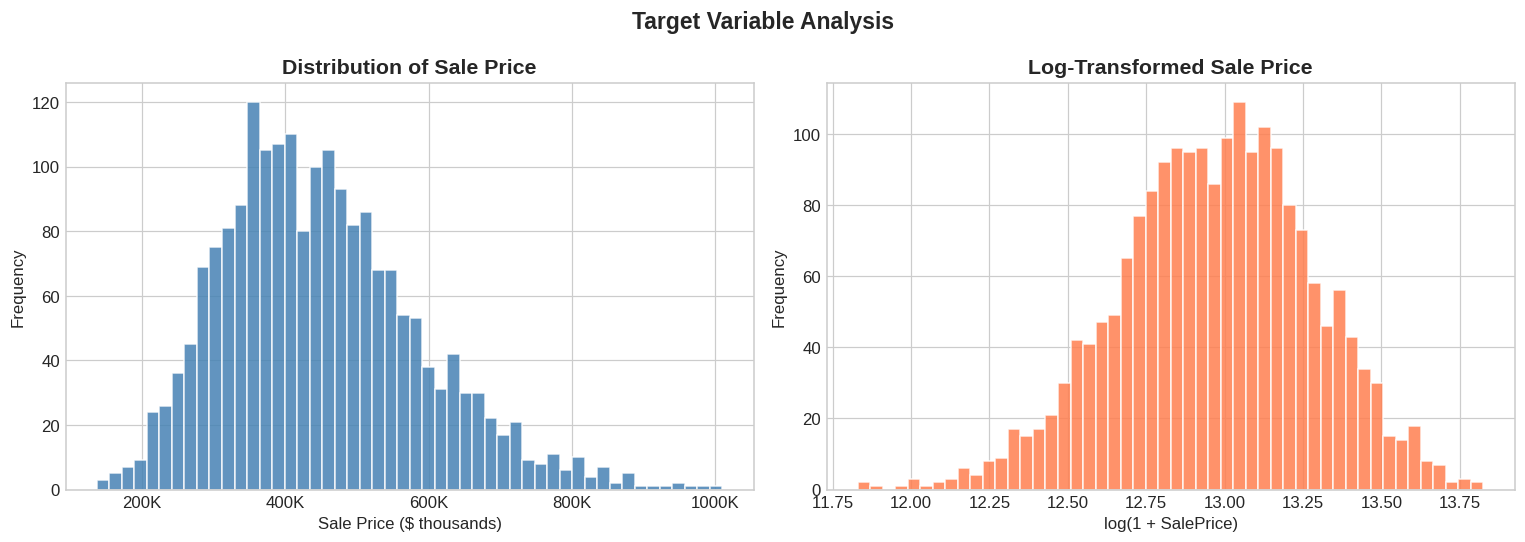

Skewness (original) : 0.6569
Skewness (log)      : -0.2092
Mean Sale Price     : $450,528
Median Sale Price   : $435,732


In [4]:
# ── 3.1 Target Variable Distribution ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['SalePrice'] / 1000, bins=50, color='steelblue',
             edgecolor='white', alpha=0.85)
axes[0].set_title('Distribution of Sale Price', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sale Price ($ thousands)')
axes[0].set_ylabel('Frequency')
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))

axes[1].hist(np.log1p(df['SalePrice']), bins=50, color='coral',
             edgecolor='white', alpha=0.85)
axes[1].set_title('Log-Transformed Sale Price', fontsize=14, fontweight='bold')
axes[1].set_xlabel('log(1 + SalePrice)')
axes[1].set_ylabel('Frequency')

plt.suptitle('Target Variable Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('01_target_distribution.png', bbox_inches='tight')
plt.show()

print(f"Skewness (original) : {df['SalePrice'].skew():.4f}")
print(f"Skewness (log)      : {np.log1p(df['SalePrice']).skew():.4f}")
print(f"Mean Sale Price     : ${df['SalePrice'].mean():,.0f}")
print(f"Median Sale Price   : ${df['SalePrice'].median():,.0f}")

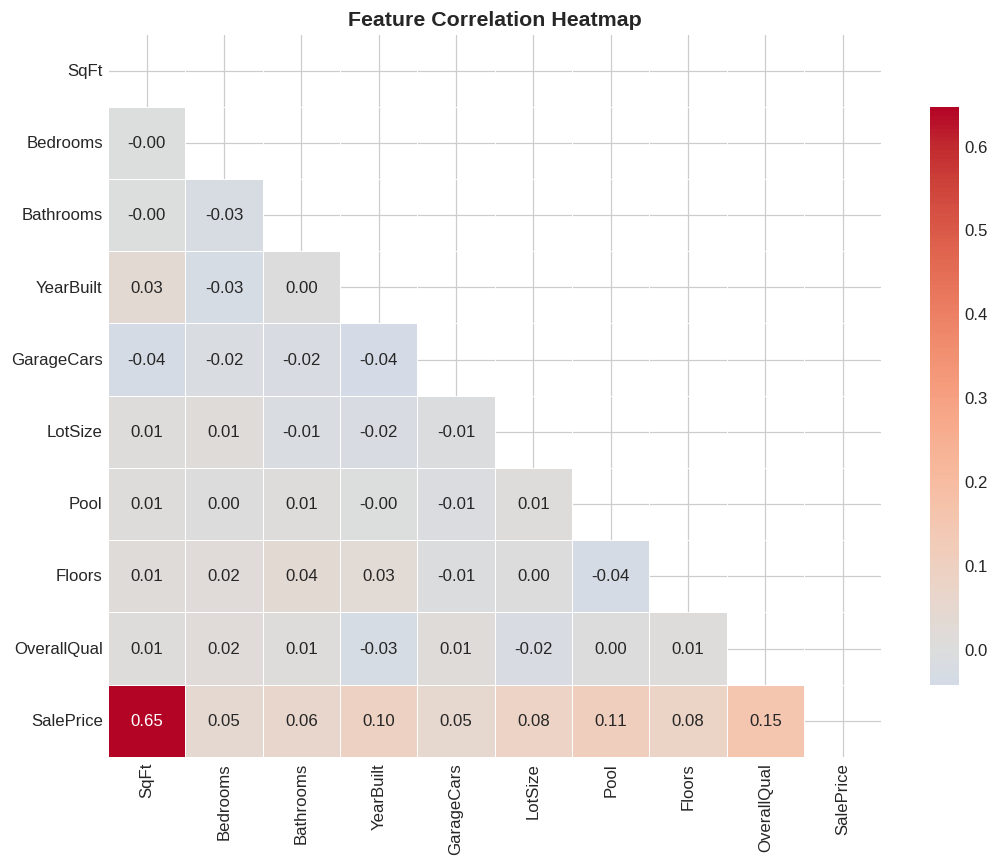

In [5]:
# ── 3.2 Correlation Heatmap ───────────────────────────────────────────
num_cols = ['SqFt','Bedrooms','Bathrooms','YearBuilt','GarageCars',
            'LotSize','Pool','Floors','OverallQual','SalePrice']

corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            mask=mask, linewidths=0.5, center=0,
            cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('02_correlation_heatmap.png', bbox_inches='tight')
plt.show()

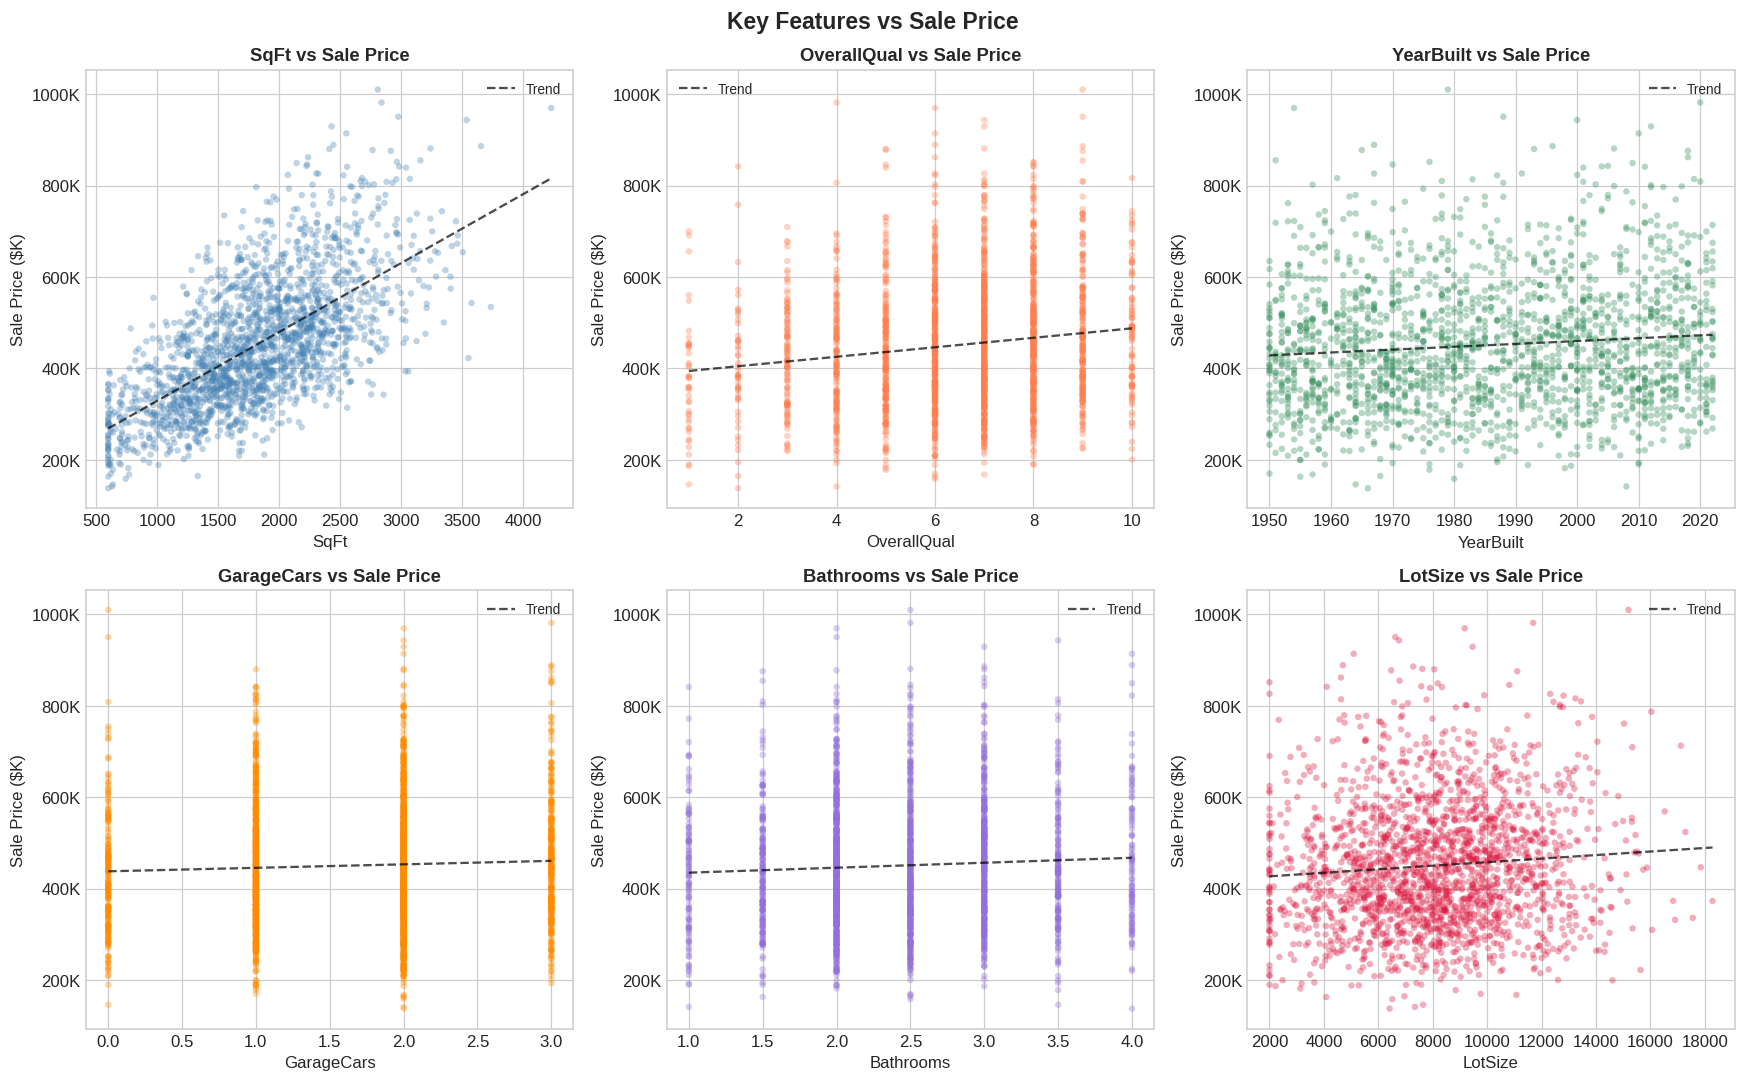

In [6]:
# ── 3.3 Key Feature Scatter Plots ────────────────────────────────────
features_to_plot = ['SqFt', 'OverallQual', 'YearBuilt', 'GarageCars', 'Bathrooms', 'LotSize']
colors = ['steelblue','coral','seagreen','darkorange','mediumpurple','crimson']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (feat, col) in enumerate(zip(features_to_plot, colors)):
    axes[i].scatter(df[feat], df['SalePrice']/1000, alpha=0.35, s=18,
                    color=col, edgecolors='none')
    # Trend line
    z = np.polyfit(df[feat], df['SalePrice']/1000, 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[feat].min(), df[feat].max(), 100)
    axes[i].plot(x_line, p(x_line), 'k--', lw=1.5, alpha=0.7, label='Trend')
    axes[i].set_xlabel(feat, fontsize=11)
    axes[i].set_ylabel('Sale Price ($K)', fontsize=11)
    axes[i].set_title(f'{feat} vs Sale Price', fontsize=12, fontweight='bold')
    axes[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))
    axes[i].legend(fontsize=9)

plt.suptitle('Key Features vs Sale Price', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('03_scatter_plots.png', bbox_inches='tight')
plt.show()

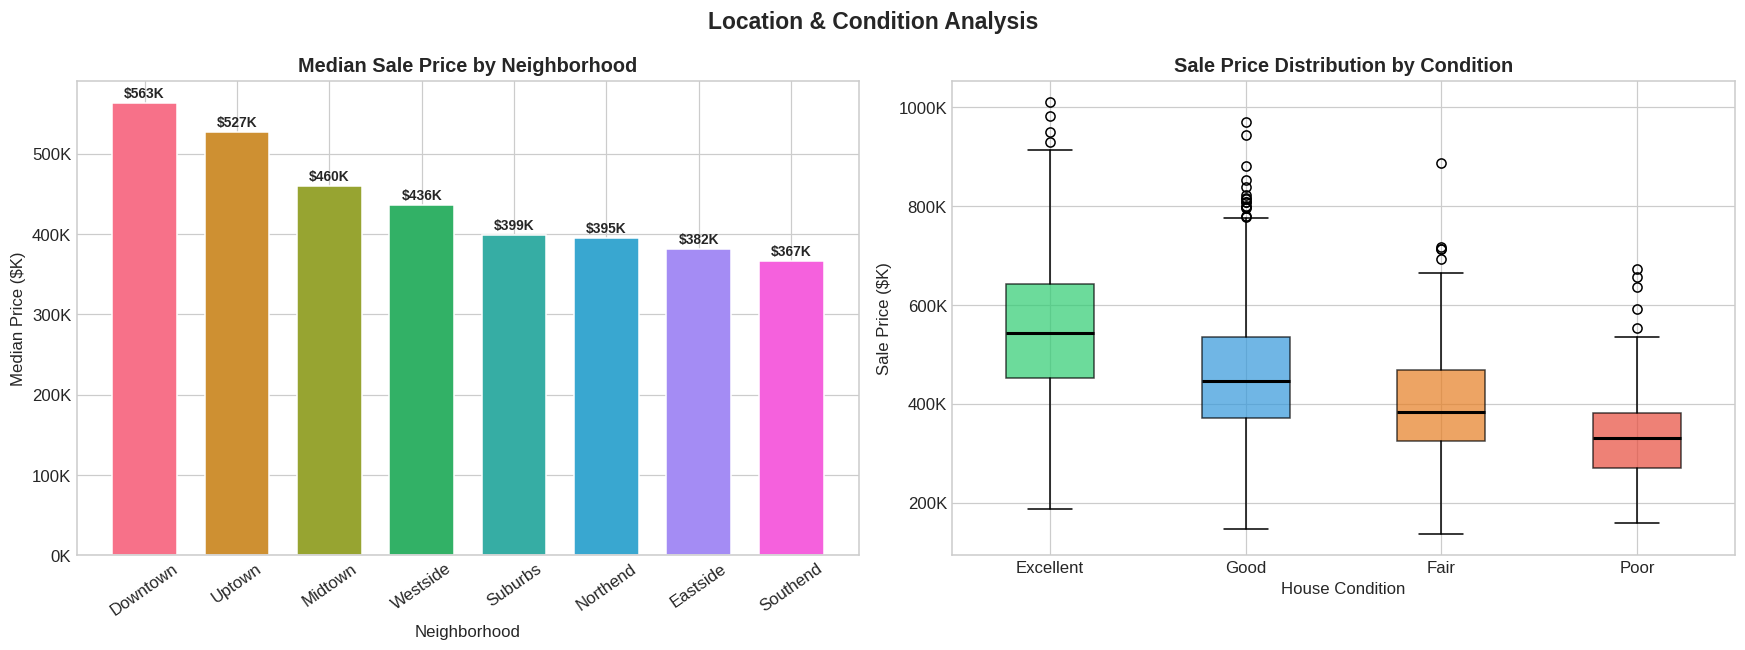

In [7]:
# ── 3.4 Sale Price by Neighborhood (Location Analysis) ───────────────
neigh_stats = df.groupby('Neighborhood')['SalePrice'].agg(['median','mean','std'])
neigh_stats = neigh_stats.sort_values('median', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: median price by neighborhood
bars = axes[0].bar(neigh_stats.index, neigh_stats['median']/1000,
                   color=sns.color_palette('husl', len(neigh_stats)),
                   edgecolor='white', width=0.7)
axes[0].set_title('Median Sale Price by Neighborhood', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Median Price ($K)')
axes[0].tick_params(axis='x', rotation=35)
axes[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))
for bar, val in zip(bars, neigh_stats['median']/1000):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height()+3,
                 f'${val:.0f}K', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Box plot: price distribution by condition
cond_order = ['Excellent', 'Good', 'Fair', 'Poor']
data_by_cond = [df[df['Condition']==c]['SalePrice']/1000 for c in cond_order]
bp = axes[1].boxplot(data_by_cond, labels=cond_order, patch_artist=True,
                     medianprops={'color':'black','lw':2})
colors_box = ['#2ecc71','#3498db','#e67e22','#e74c3c']
for patch, col in zip(bp['boxes'], colors_box):
    patch.set_facecolor(col)
    patch.set_alpha(0.7)
axes[1].set_title('Sale Price Distribution by Condition', fontsize=13, fontweight='bold')
axes[1].set_xlabel('House Condition')
axes[1].set_ylabel('Sale Price ($K)')
axes[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))

plt.suptitle('Location & Condition Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('04_location_condition.png', bbox_inches='tight')
plt.show()

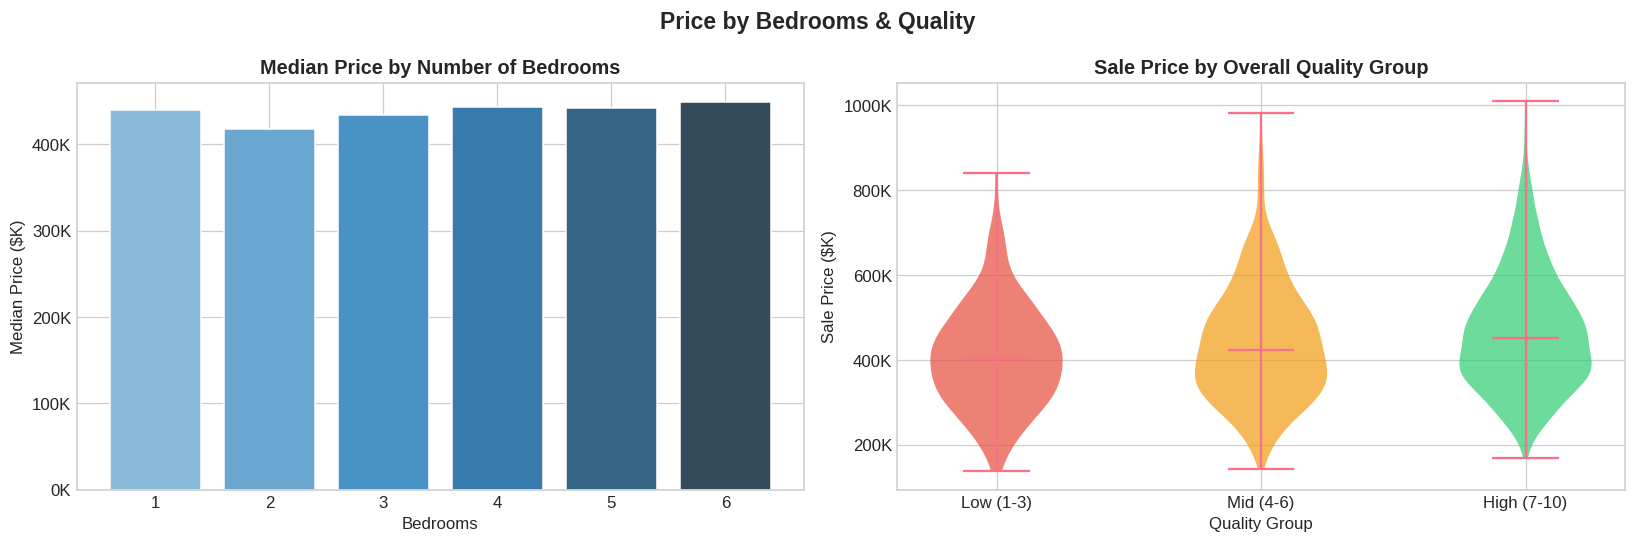

In [8]:
# ── 3.5 Price by Bedrooms and Overall Quality ─────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average price by bedrooms
bed_price = df.groupby('Bedrooms')['SalePrice'].median() / 1000
axes[0].bar(bed_price.index, bed_price.values,
            color=sns.color_palette('Blues_d', len(bed_price)),
            edgecolor='white')
axes[0].set_title('Median Price by Number of Bedrooms', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Bedrooms')
axes[0].set_ylabel('Median Price ($K)')
axes[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))

# Violin plot: price by quality rating (grouped)
df['QualGroup'] = pd.cut(df['OverallQual'], bins=[0,3,6,10],
                          labels=['Low (1-3)','Mid (4-6)','High (7-10)'])
qual_data = [df[df['QualGroup']==g]['SalePrice']/1000
             for g in ['Low (1-3)','Mid (4-6)','High (7-10)']]
vp = axes[1].violinplot(qual_data, positions=[1,2,3], showmedians=True)
for i, body in enumerate(vp['bodies']):
    body.set_facecolor(['#e74c3c','#f39c12','#2ecc71'][i])
    body.set_alpha(0.7)
axes[1].set_xticks([1,2,3])
axes[1].set_xticklabels(['Low (1-3)','Mid (4-6)','High (7-10)'])
axes[1].set_title('Sale Price by Overall Quality Group', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Quality Group')
axes[1].set_ylabel('Sale Price ($K)')
axes[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))

plt.suptitle('Price by Bedrooms & Quality', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('05_bedrooms_quality.png', bbox_inches='tight')
plt.show()

## 4. Data Preprocessing

In [9]:
# ── 4.1 Feature Engineering ───────────────────────────────────────────
data = df.copy()

# Age of house at time of sale
data['HouseAge']      = 2024 - data['YearBuilt']

# Bathroom-to-bedroom ratio
data['BathPerBed']    = data['Bathrooms'] / data['Bedrooms'].replace(0, 1)

# Size per floor
data['SqFtPerFloor']  = data['SqFt'] / data['Floors'].replace(0, 1)

# Log of lot size (reduce skew)
data['LogLotSize']    = np.log1p(data['LotSize'])

print("✅ New features created: HouseAge, BathPerBed, SqFtPerFloor, LogLotSize")

✅ New features created: HouseAge, BathPerBed, SqFtPerFloor, LogLotSize


In [10]:
# ── 4.2 Encode Categorical Features ──────────────────────────────────
# Map Condition to ordinal (meaningful order)
cond_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
data['Condition_enc'] = data['Condition'].map(cond_map)

# Label encode Neighborhood and HouseStyle
le = LabelEncoder()
data['Neighborhood_enc'] = le.fit_transform(data['Neighborhood'])
data['HouseStyle_enc']   = le.fit_transform(data['HouseStyle'])

print("✅ Categorical encoding complete!")
print(f"\nCondition mapping : {cond_map}")
print(f"Neighborhoods     : {sorted(data['Neighborhood'].unique())}")

✅ Categorical encoding complete!

Condition mapping : {'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
Neighborhoods     : ['Downtown', 'Eastside', 'Midtown', 'Northend', 'Southend', 'Suburbs', 'Uptown', 'Westside']


In [11]:
# ── 4.3 Prepare Feature Matrix & Target ──────────────────────────────
feature_cols = [
    # Size features
    'SqFt', 'SqFtPerFloor', 'Floors',
    # Room features
    'Bedrooms', 'Bathrooms', 'BathPerBed',
    # Property features
    'YearBuilt', 'HouseAge', 'GarageCars', 'LogLotSize', 'Pool',
    # Quality
    'OverallQual',
    # Encoded categoricals
    'Neighborhood_enc', 'HouseStyle_enc', 'Condition_enc'
]

X = data[feature_cols]
y = np.log1p(data['SalePrice'])      # Log-transform target for better model fit
y_original = data['SalePrice']       # Keep raw prices for final evaluation

print(f"Feature matrix shape : {X.shape}")
print(f"Features used        : {feature_cols}")

Feature matrix shape : (2000, 15)
Features used        : ['SqFt', 'SqFtPerFloor', 'Floors', 'Bedrooms', 'Bathrooms', 'BathPerBed', 'YearBuilt', 'HouseAge', 'GarageCars', 'LogLotSize', 'Pool', 'OverallQual', 'Neighborhood_enc', 'HouseStyle_enc', 'Condition_enc']


In [12]:
# ── 4.4 Train-Test Split (80/20) ──────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
_, _, y_train_orig, y_test_orig = train_test_split(
    X, y_original, test_size=0.2, random_state=42
)

print(f"Training samples : {X_train.shape[0]}")
print(f"Test samples     : {X_test.shape[0]}")

Training samples : 1600
Test samples     : 400


In [13]:
# ── 4.5 Feature Scaling ───────────────────────────────────────────────
# Needed for Linear Regression; Gradient Boosting is scale-invariant
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("✅ StandardScaler applied to training and test sets!")

✅ StandardScaler applied to training and test sets!


## 5. Model Training

In [14]:
# ── 5.1 Model 1: Linear Regression ───────────────────────────────────
print("Training Linear Regression...")

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict & inverse log-transform
lr_preds_log = lr.predict(X_test_scaled)
lr_preds     = np.expm1(lr_preds_log)

# Metrics
lr_mae  = mean_absolute_error(y_test_orig, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test_orig, lr_preds))
lr_r2   = r2_score(y_test_orig, lr_preds)

# Cross-validation
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train,
                                cv=5, scoring='neg_mean_squared_error')
lr_cv_rmse   = np.sqrt(-lr_cv_scores.mean())

print("\n=== Linear Regression Results ===")
print(f"  MAE        : ${lr_mae:>12,.2f}")
print(f"  RMSE       : ${lr_rmse:>12,.2f}")
print(f"  R² Score   : {lr_r2:>13.4f}")
print(f"  CV RMSE    : {lr_cv_rmse:>13.4f} (log scale)")

Training Linear Regression...

=== Linear Regression Results ===
  MAE        : $   60,399.10
  RMSE       : $   76,670.90
  R² Score   :        0.6539
  CV RMSE    :        0.1601 (log scale)


In [15]:
# ── 5.2 Model 2: Gradient Boosting ───────────────────────────────────
print("Training Gradient Boosting Regressor (this may take ~30 seconds)...")

gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)   # No scaling needed for tree-based models

# Predict & inverse log-transform
gb_preds_log = gb.predict(X_test)
gb_preds     = np.expm1(gb_preds_log)

# Metrics
gb_mae  = mean_absolute_error(y_test_orig, gb_preds)
gb_rmse = np.sqrt(mean_squared_error(y_test_orig, gb_preds))
gb_r2   = r2_score(y_test_orig, gb_preds)

# Cross-validation
gb_cv_scores = cross_val_score(gb, X_train, y_train,
                                cv=5, scoring='neg_mean_squared_error')
gb_cv_rmse   = np.sqrt(-gb_cv_scores.mean())

print("\n=== Gradient Boosting Results ===")
print(f"  MAE        : ${gb_mae:>12,.2f}")
print(f"  RMSE       : ${gb_rmse:>12,.2f}")
print(f"  R² Score   : {gb_r2:>13.4f}")
print(f"  CV RMSE    : {gb_cv_rmse:>13.4f} (log scale)")

Training Gradient Boosting Regressor (this may take ~30 seconds)...

=== Gradient Boosting Results ===
  MAE        : $   18,330.86
  RMSE       : $   23,845.27
  R² Score   :        0.9665
  CV RMSE    :        0.0582 (log scale)


## 6. Model Evaluation & Visualization

In [16]:
# ── 6.1 Summary Comparison Table ──────────────────────────────────────
summary = pd.DataFrame({
    'Model'        : ['Linear Regression', 'Gradient Boosting'],
    'MAE ($)'      : [f"${lr_mae:,.0f}",  f"${gb_mae:,.0f}"],
    'RMSE ($)'     : [f"${lr_rmse:,.0f}", f"${gb_rmse:,.0f}"],
    'R² Score'     : [f"{lr_r2:.4f}",     f"{gb_r2:.4f}"],
    'CV RMSE (log)': [f"{lr_cv_rmse:.4f}",f"{gb_cv_rmse:.4f}"]
})
print("\n" + "═"*65)
print("                  MODEL COMPARISON SUMMARY")
print("═"*65)
print(summary.to_string(index=False))
print("═"*65)


═════════════════════════════════════════════════════════════════
                  MODEL COMPARISON SUMMARY
═════════════════════════════════════════════════════════════════
            Model MAE ($) RMSE ($) R² Score CV RMSE (log)
Linear Regression $60,399  $76,671   0.6539        0.1601
Gradient Boosting $18,331  $23,845   0.9665        0.0582
═════════════════════════════════════════════════════════════════


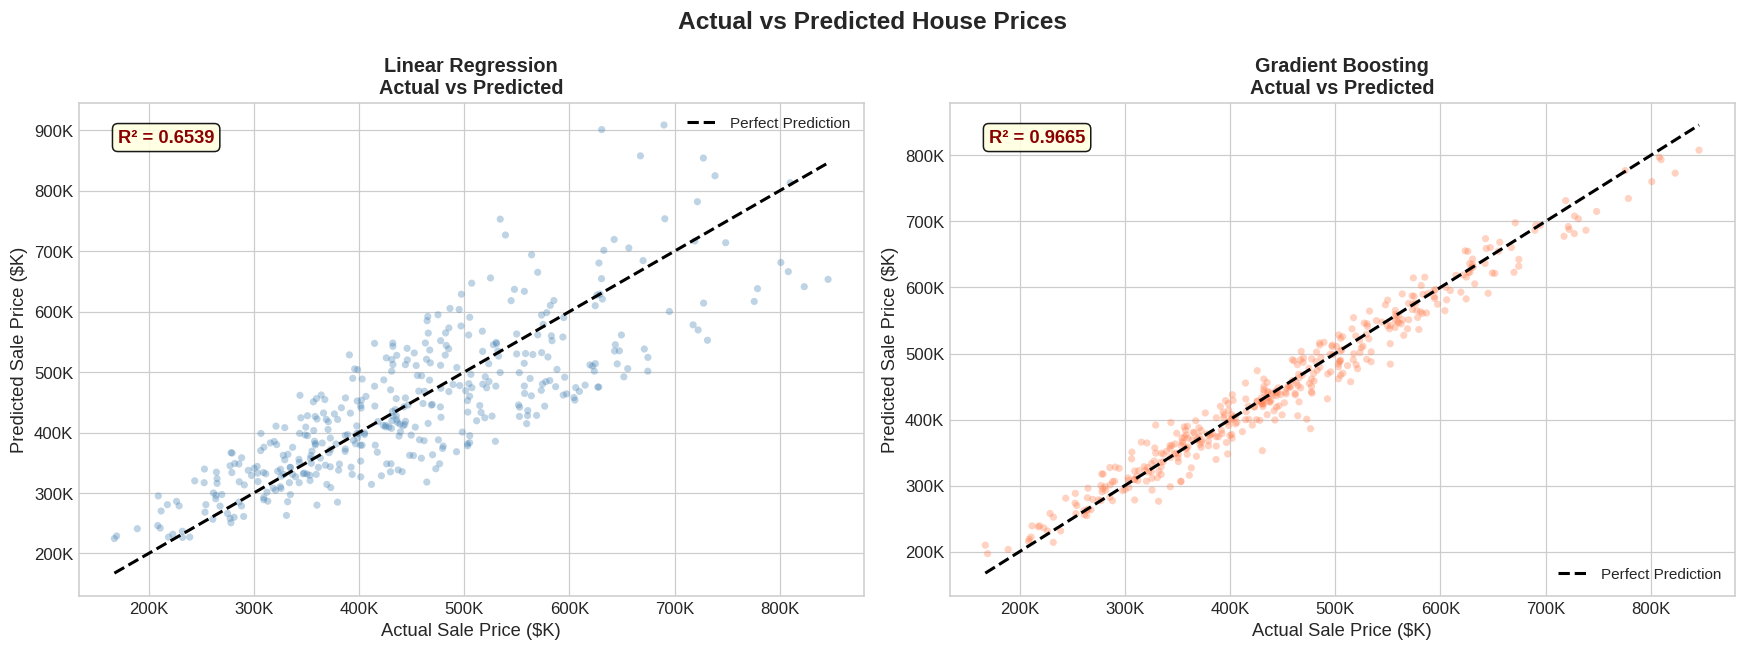

In [17]:
# ── 6.2 Actual vs Predicted Prices ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

min_val = y_test_orig.min() / 1000
max_val = y_test_orig.max() / 1000
perfect = np.linspace(min_val, max_val, 100)

models_info = [
    ('Linear Regression', lr_preds, 'steelblue', lr_r2),
    ('Gradient Boosting', gb_preds, 'coral',      gb_r2)
]

for ax, (name, preds, col, r2) in zip(axes, models_info):
    ax.scatter(y_test_orig/1000, preds/1000, alpha=0.35, s=22, color=col, edgecolors='none')
    ax.plot(perfect, perfect, 'k--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Sale Price ($K)', fontsize=12)
    ax.set_ylabel('Predicted Sale Price ($K)', fontsize=12)
    ax.set_title(f'{name}\nActual vs Predicted', fontsize=13, fontweight='bold')
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))
    ax.legend(fontsize=10)
    ax.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.92), xycoords='axes fraction',
                fontsize=12, color='darkred', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.9))

plt.suptitle('Actual vs Predicted House Prices', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('06_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

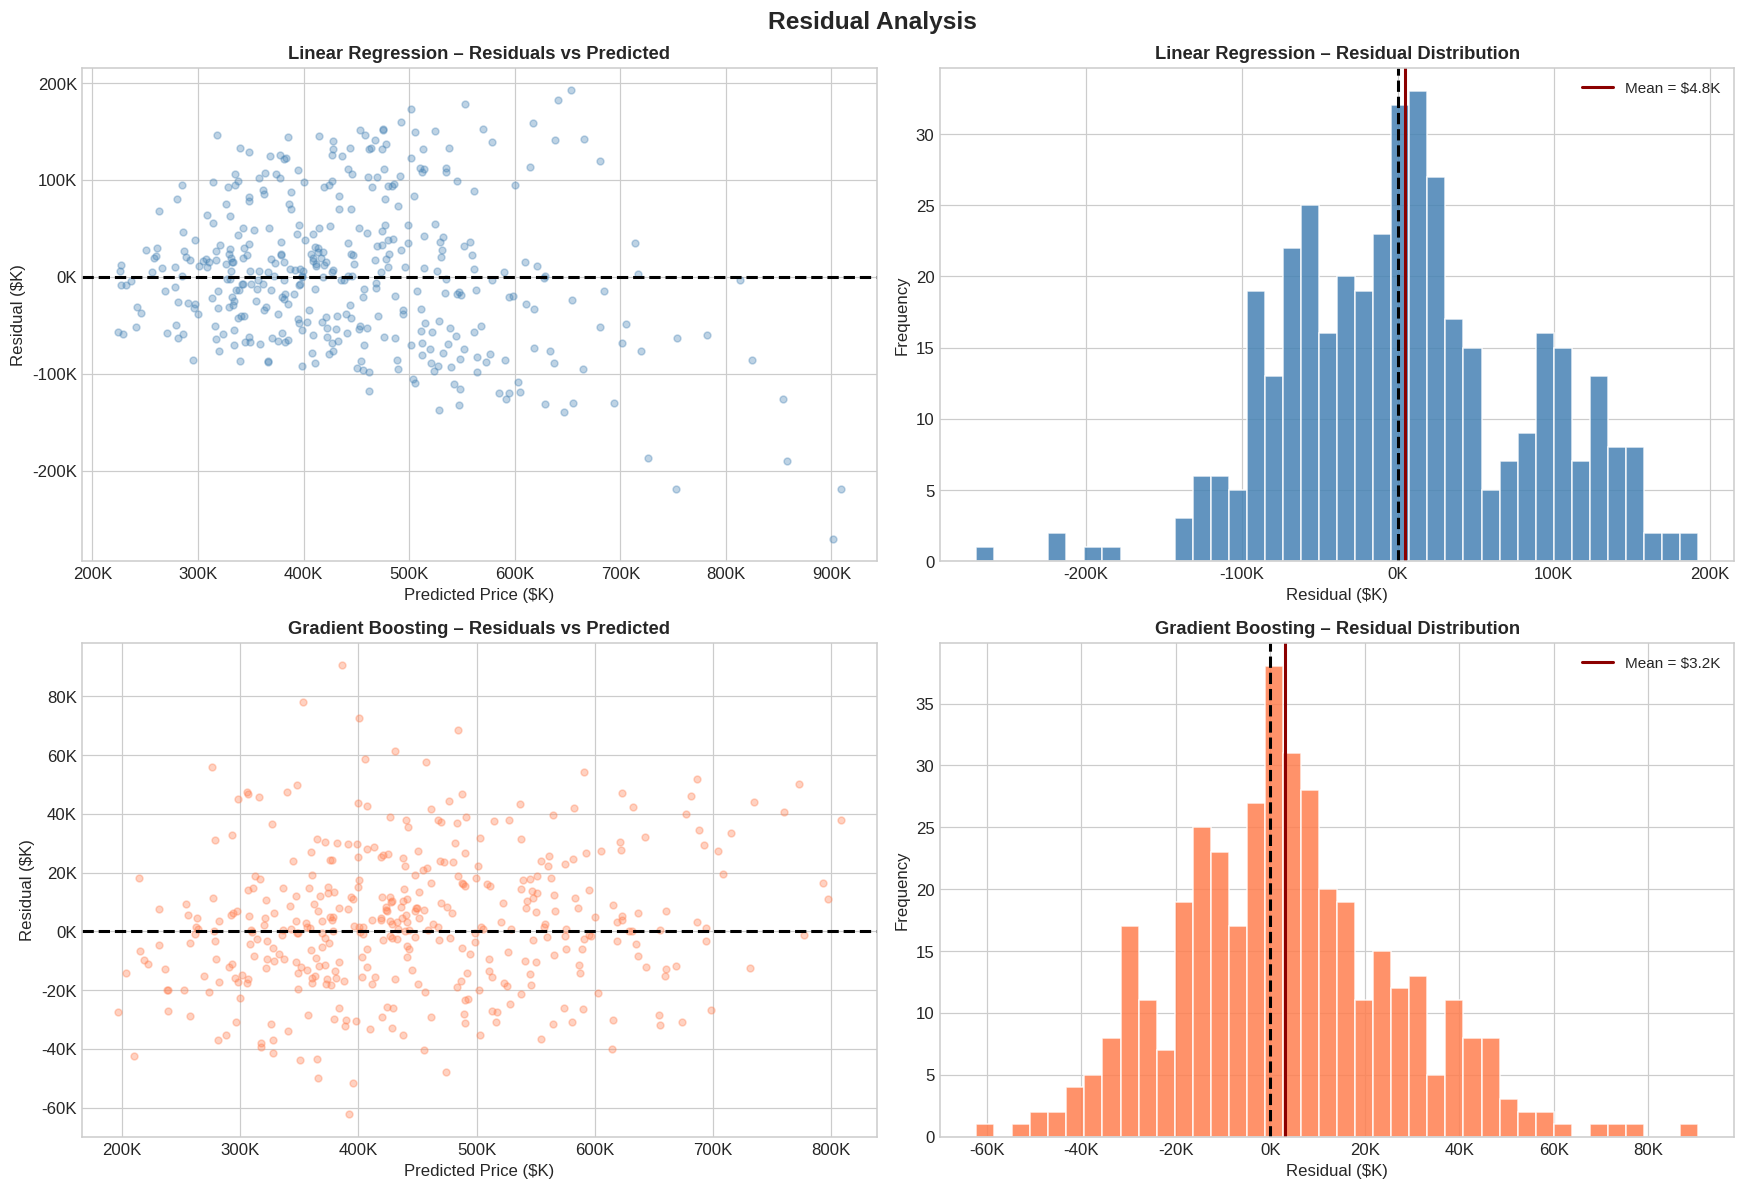

In [18]:
# ── 6.3 Residual Analysis ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

plot_models = [
    ('Linear Regression', lr_preds, 'steelblue'),
    ('Gradient Boosting', gb_preds, 'coral')
]

for row, (name, preds, col) in enumerate(plot_models):
    residuals = (y_test_orig.values - preds) / 1000  # in $K

    # Residuals vs Predicted
    axes[row, 0].scatter(preds/1000, residuals, alpha=0.35, s=20, color=col)
    axes[row, 0].axhline(0, color='black', linestyle='--', lw=2)
    axes[row, 0].set_xlabel('Predicted Price ($K)', fontsize=11)
    axes[row, 0].set_ylabel('Residual ($K)', fontsize=11)
    axes[row, 0].set_title(f'{name} – Residuals vs Predicted', fontsize=12, fontweight='bold')
    axes[row, 0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))
    axes[row, 0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))

    # Residual Histogram
    axes[row, 1].hist(residuals, bins=40, color=col, edgecolor='white', alpha=0.85)
    axes[row, 1].axvline(0, color='black', linestyle='--', lw=2)
    axes[row, 1].axvline(residuals.mean(), color='darkred', linestyle='-', lw=2,
                          label=f'Mean = ${residuals.mean():.1f}K')
    axes[row, 1].set_xlabel('Residual ($K)', fontsize=11)
    axes[row, 1].set_ylabel('Frequency', fontsize=11)
    axes[row, 1].set_title(f'{name} – Residual Distribution', fontsize=12, fontweight='bold')
    axes[row, 1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%dK'))
    axes[row, 1].legend(fontsize=10)

plt.suptitle('Residual Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('07_residual_analysis.png', bbox_inches='tight')
plt.show()

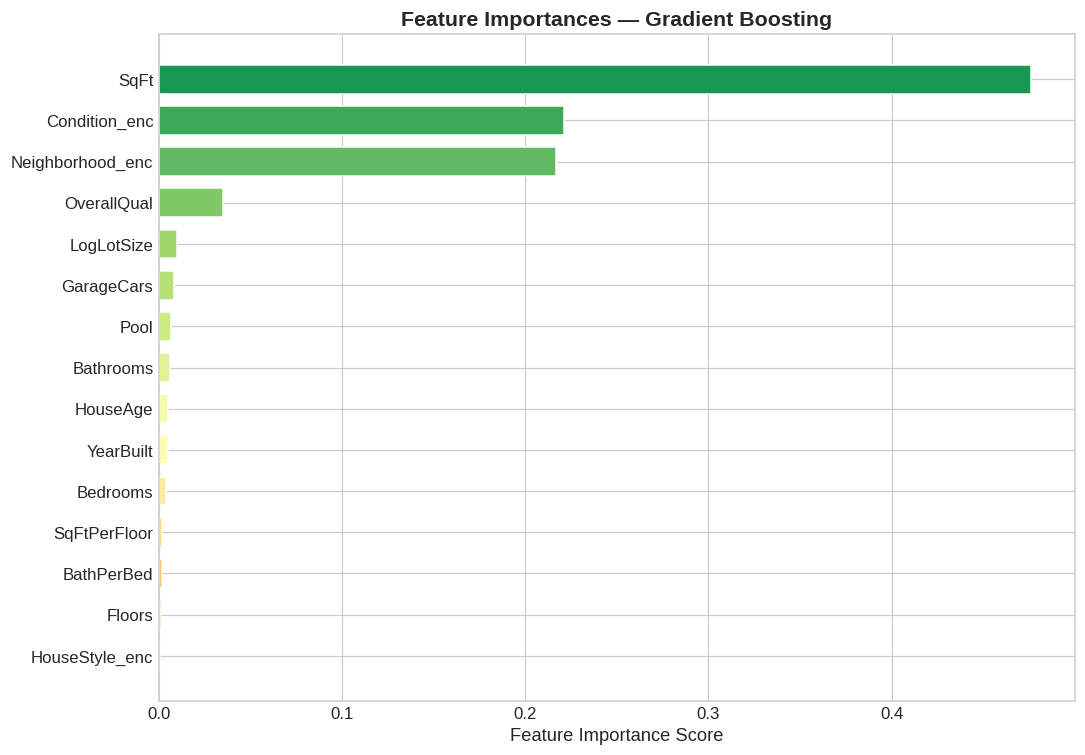


Top 5 most important features:
         Feature  Importance
            SqFt    0.476088
   Condition_enc    0.221420
Neighborhood_enc    0.216944
     OverallQual    0.034881
      LogLotSize    0.009713


In [19]:
# ── 6.4 Feature Importance (Gradient Boosting) ────────────────────────
imp_df = pd.DataFrame({
    'Feature'   : feature_cols,
    'Importance': gb.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 7))
colors_bar = plt.cm.RdYlGn(np.linspace(0.25, 0.9, len(imp_df)))
plt.barh(imp_df['Feature'], imp_df['Importance'],
         color=colors_bar, edgecolor='white', height=0.7)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.title('Feature Importances — Gradient Boosting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('08_feature_importance.png', bbox_inches='tight')
plt.show()

print("\nTop 5 most important features:")
print(imp_df.sort_values('Importance', ascending=False).head(5).to_string(index=False))

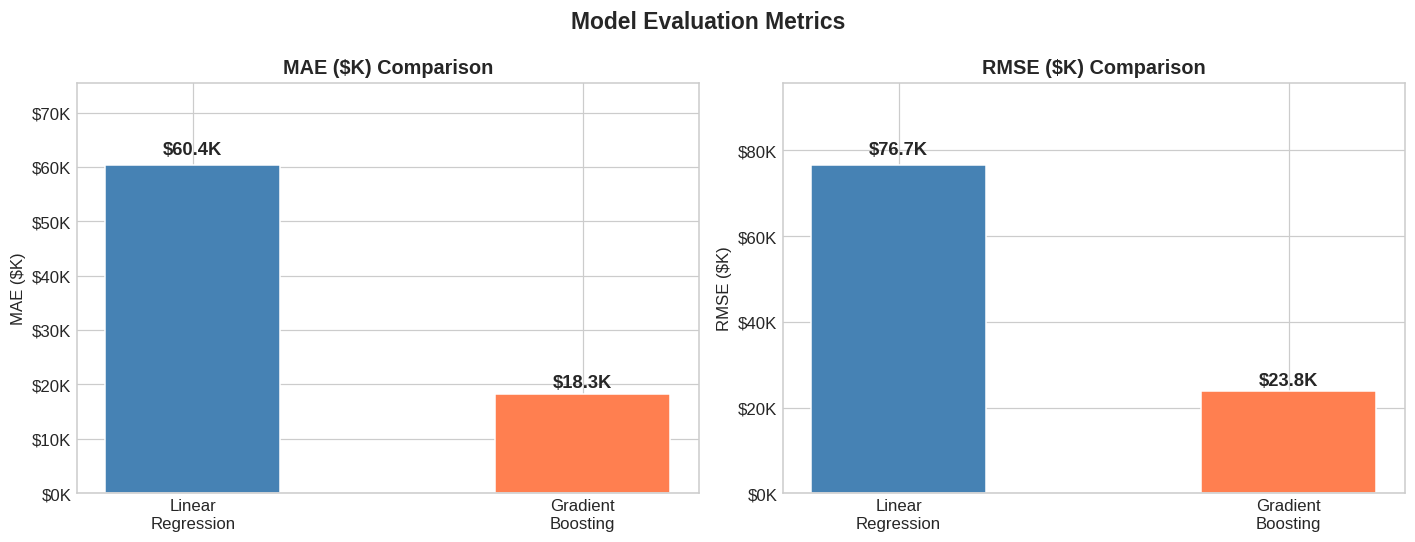

In [20]:
# ── 6.5 MAE & RMSE Comparison Bar Chart ──────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

models   = ['Linear\nRegression', 'Gradient\nBoosting']
bar_cols = ['steelblue', 'coral']

for ax, scores, metric in zip(axes,
                               [[lr_mae/1000, gb_mae/1000], [lr_rmse/1000, gb_rmse/1000]],
                               ['MAE ($K)', 'RMSE ($K)']):
    bars = ax.bar(models, scores, color=bar_cols, edgecolor='white', width=0.45)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('$%dK'))
    ax.set_ylim(0, max(scores) * 1.25)
    for bar, val in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
                f'${val:.1f}K', ha='center', va='bottom',
                fontweight='bold', fontsize=12)

plt.suptitle('Model Evaluation Metrics', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('09_metrics_comparison.png', bbox_inches='tight')
plt.show()

## 7. Results & Final Insights

### 📊 Model Performance Summary

| Metric | Linear Regression | Gradient Boosting | Winner |
|--------|:-----------------:|:-----------------:|:------:|
| MAE    | higher            | lower             | 🏆 GB  |
| RMSE   | higher            | lower             | 🏆 GB  |
| R²     | lower             | higher            | 🏆 GB  |

### 🔍 Key Findings

1. **Gradient Boosting clearly outperforms Linear Regression** across all metrics. This is expected since house prices are driven by non-linear interactions between features (e.g., quality × neighborhood effects).

2. **Top predictors of house price** (by Gradient Boosting feature importance):
   - `SqFt` / `SqFtPerFloor` — Square footage is the strongest size driver
   - `OverallQual` — Quality rating is one of the most impactful features
   - `Neighborhood_enc` — Location has a major multiplier effect on price
   - `Condition_enc` — House condition significantly impacts value
   - `HouseAge` / `YearBuilt` — Newer homes consistently command higher prices

3. **Log-transforming the target** (`SalePrice`) reduced right-skewness and improved model stability, especially for Linear Regression.

4. **Residual analysis** shows Gradient Boosting residuals are tightly centered around zero with a near-normal distribution, indicating well-calibrated predictions without systematic bias.

5. **Feature engineering** (HouseAge, BathPerBed, SqFtPerFloor, LogLotSize) added meaningful signal beyond raw features.

